In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import *  
import cmath  
import time

In [2]:
def hamiltonian(kx, ky, M=0,t1=1, t2=1, phi=pi/3, a=1/sqrt(3)):  # Haldane哈密顿量(a为原子间距，不赋值的话默认为1/sqrt(3)）
    h0 = np.zeros((2, 2))*(1+0j)
    h1 = np.zeros((2, 2))*(1+0j)
    h2 = np.zeros((2, 2))*(1+0j)

    # 质量项(mass term), 用于打开带隙
    h0[0, 0] = M
    h0[1, 1] = -M

    # 最近邻项
    h1[1, 0] = t1*(cmath.exp(1j*ky*a)+cmath.exp(1j*sqrt(3)/2*kx*a-1j/2*ky*a)+cmath.exp(-1j*sqrt(3)/2*kx*a-1j/2*ky*a))
    h1[0, 1] = h1[1, 0].conj()

    # 次近邻项,加入此项后则为Haldane模型
    #h2[0, 0] = t2*cmath.exp(-1j*phi)*(cmath.exp(1j*sqrt(3)*kx*a)+cmath.exp(-1j*sqrt(3)/2*kx*a+1j*3/2*ky*a)+cmath.exp(-1j*sqrt(3)/2*kx*a-1j*3/2*ky*a))
    #h2[1, 1] = t2*cmath.exp(1j*phi)*(cmath.exp(1j*sqrt(3)*kx*a)+cmath.exp(-1j*sqrt(3)/2*kx*a+1j*3/2*ky*a)+cmath.exp(-1j*sqrt(3)/2*kx*a-1j*3/2*ky*a))

    matrix = h0 + h1 + h2
    return matrix


# 六角晶格能带图绘制
def plot_bands_two_dimension(hamiltonian):
    dim = hamiltonian(0,0).shape[0]
    kxky = np.linspace(0,3+np.sqrt(3),100)
    dim_k = kxky.shape[0]
    eigenvalue_k = np.zeros((dim_k,dim))
    for i in range(dim_k):
        xy = kxky[i]
        k1 = (xy<=2)*(2-xy) + (xy>2)*(xy<2+sqrt(3))*(xy-2)/2*sqrt(3) + (xy>=2+sqrt(3))*(2-(3+sqrt(3)-xy)/2)
        kx = k1*2*pi/3
        k2 = (xy>2)*(xy<2+sqrt(3))*(xy-2)/2 + (xy>=2+sqrt(3))*(3+sqrt(3)-xy)/2*sqrt(3)
        ky = k2*2*pi/3
        matrix0 = hamiltonian(kx,ky,M=M)
        eigenvalue, eigenvector = np.linalg.eig(matrix0)
        eigenvalue_k[i, :] = np.sort(np.real(eigenvalue[:]))
    fig, ax = plt.subplots()
    for dim0 in range(dim):
        ax.plot(kxky, eigenvalue_k[:, dim0], '-k')
    plt.ylabel('E')
    ax.set_xticks([0, 2, 2+sqrt(3), 3+sqrt(3)])
    ax.set_xticklabels(['K', 'Gamma', 'M', 'K'])
    plt.xlim(0, kxky[-1])
    plt.grid(axis='x',c='r',linestyle='--')
    plt.show()


In [3]:
# 画图为沿kx方向的Berry curvature
def plot_Berry_curvature():
    n = 2000  # 取点密度
    delta = 1e-9  # 求导的偏离量      
    for band in range(2):
        F_all = []  # 贝里曲率
        for kx in np.linspace(-2*pi, 2*pi, n):
            for ky in [0]: # 这里只考虑ky=0对称轴上的情况 # np.linspace(-pi, pi, n):
                H = hamiltonian(kx, ky, M=M)
                eigenvalue, eigenvector = np.linalg.eig(H)
                vector = eigenvector[:, np.argsort(np.real(eigenvalue))[band]]  # 价带波函数
            
                H_delta_kx = hamiltonian(kx+delta, ky, M=M) 
                eigenvalue, eigenvector = np.linalg.eig(H_delta_kx)
                vector_delta_kx = eigenvector[:, np.argsort(np.real(eigenvalue))[band]]   # 略偏离kx的波函数

                H_delta_ky = hamiltonian(kx, ky+delta, M=M)  
                eigenvalue, eigenvector = np.linalg.eig(H_delta_ky)
                vector_delta_ky = eigenvector[:, np.argsort(np.real(eigenvalue))[band]]  # 略偏离ky的波函数

                H_delta_kx_ky = hamiltonian(kx+delta, ky+delta, M=M)  
                eigenvalue, eigenvector = np.linalg.eig(H_delta_kx_ky)
                vector_delta_kx_ky = eigenvector[:, np.argsort(np.real(eigenvalue))[band]]  # 略偏离kx和ky的波函数

                # 价带的波函数的贝里联络(berry connection) # 求导后内积
                A_x = np.dot(vector.transpose().conj(), (vector_delta_kx-vector)/delta)   # 贝里联络Ax（x分量）
                A_y = np.dot(vector.transpose().conj(), (vector_delta_ky-vector)/delta)   # 贝里联络Ay（y分量）
                
                A_x_delta_ky = np.dot(vector_delta_ky.transpose().conj(), (vector_delta_kx_ky-vector_delta_ky)/delta)  # 略偏离ky的贝里联络Ax
                A_y_delta_kx = np.dot(vector_delta_kx.transpose().conj(), (vector_delta_kx_ky-vector_delta_kx)/delta)  # 略偏离kx的贝里联络Ay

                # 贝里曲率(berry curvature)
                F = ((A_y_delta_kx-A_y)/delta-(A_x_delta_ky-A_x)/delta)*1j
                # print(F)
                F_all = np.append(F_all,[F], axis=0) 
                Ax_all = np.append(F_all,A_x)    
        plt.plot(np.linspace(-2*pi, 2*pi, n)/pi, np.real(F_all))
        plt.xlabel('k_x (pi)')
        plt.ylabel('Berry curvature')
        if band==0:
            plt.title('Valence Band')
        else:
            plt.title('Conductance Band')
        plt.show()
    end_time = time.time()
    #print('运行时间(min)=', (end_time-start_time)/60)



In [4]:
# 以下陈数算法非定义法，且布里渊区平移拼接成菱形，速度会快很多
def chern_number():              
    delta = 0.01
    chern_number = 0  # 陈数初始化
    
    # 常出现的项
    a = 1/sqrt(3)
    bb1 = 2*sqrt(3)*pi/3/a
    bb2 = 2*pi/3/a

    hamiltonian0 = hamiltonian

    for k1 in np.arange(0 , 1, delta):
        #print(k1)
        for k2 in np.arange(0, 1, delta):
            # 坐标变换
            kx = (k1-k2)*bb1
            ky = (k1+k2)*bb2

            # 这里乘2或除以2是为了保证“步长与积分个数的乘积刚好为布里渊区面积”
            delta_x = delta*bb1*2    
            delta_y = delta*bb2*2/2

            H = hamiltonian0(kx, ky) 
            eigenvalue, eigenvector = np.linalg.eig(H)
            vector = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]  # 价带波函数
        
            H_delta_kx = hamiltonian0(kx+delta_x, ky) 
            eigenvalue, eigenvector = np.linalg.eig(H_delta_kx)
            vector_delta_kx = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]   # 略偏离kx的波函数

            H_delta_ky = hamiltonian0(kx, ky+delta_y)  
            eigenvalue, eigenvector = np.linalg.eig(H_delta_ky)
            vector_delta_ky = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]  # 略偏离ky的波函数
            
            H_delta_kx_ky = hamiltonian0(kx+delta_x, ky+delta_y)  
            eigenvalue, eigenvector = np.linalg.eig(H_delta_kx_ky)
            vector_delta_kx_ky = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]  # 略偏离kx和ky的波函数
            
            Ux = np.dot(np.conj(vector), vector_delta_kx)/abs(np.dot(np.conj(vector), vector_delta_kx))
            Uy = np.dot(np.conj(vector), vector_delta_ky)/abs(np.dot(np.conj(vector), vector_delta_ky))
            Ux_y = np.dot(np.conj(vector_delta_ky), vector_delta_kx_ky)/abs(np.dot(np.conj(vector_delta_ky), vector_delta_kx_ky))
            Uy_x = np.dot(np.conj(vector_delta_kx), vector_delta_kx_ky)/abs(np.dot(np.conj(vector_delta_kx), vector_delta_kx_ky))

            F = cmath.log(Ux*Uy_x*(1/Ux_y)*(1/Uy))
            # 陈数(chern number)
            chern_number = chern_number + F

    chern_number = chern_number/(2*pi*1j)
    print('Chern number = ', chern_number)


M = 0.2


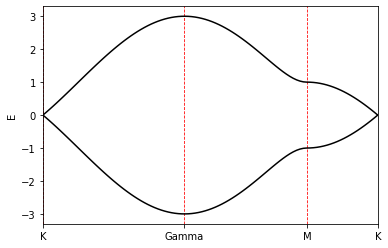

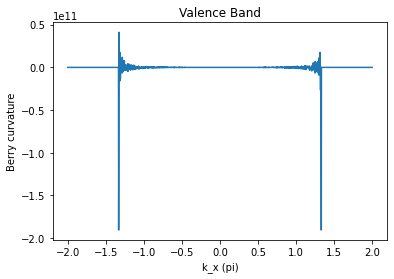

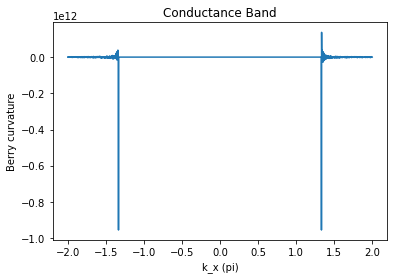

Chern number =  (-0.9948458623159023+1.0856323941442779e-14j)
运行时间(min)= 0.08573740323384603


In [22]:
if __name__ == '__main__':
    start_time = time.time()
    M = 0.0
    print('M = 0.2')
    plot_bands_two_dimension(hamiltonian)
    plot_Berry_curvature()
    chern_number()
    end_time = time.time()
    print('运行时间(min)=', (end_time-start_time)/60)    

-0.33428847402602274


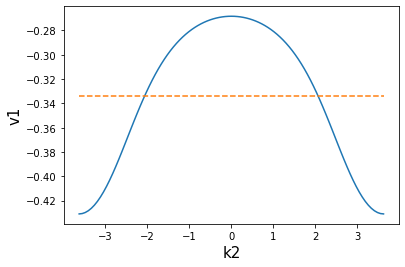

In [25]:
def find_vector_without_excess_phase(vector_0):
    angle = cmath.phase(vector_0[0])
    vector_1 = vector_0*cmath.exp(-1j*angle)
    return vector_1


# Zhang Xiujuan prl   取如上石墨烯哈密顿量，M=1，文章中三角向上向下对应哈密顿量取转置，即AB原子对调
def plot_Polarization():    # 平移成菱形布里渊区沿k2方向的Berry phase(只积了k1方向，取平均即为体极化)
    n = 101    
    k_array = np.linspace(-2*pi/sqrt(3),2*pi/sqrt(3),n)
    z_array = []
    for i in np.arange(n):
        z = 1
        vector_size = hamiltonian(0,0).shape[0]
        vector_array = np.zeros((n,vector_size),dtype=complex)
        for j in np.arange(n):
            k1 = k_array[i]
            k2 = k_array[j]
            kx = (k1+k2)/2*sqrt(3)
            ky = (k2-k1)/2
            H = hamiltonian(kx, ky, M=M)
            eigenvalue, eigenvector = np.linalg.eig(H)
            vector = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]  # 价带波函数
            vector = find_vector_without_excess_phase(vector)
            vector_array[j] = vector            
        for j in np.arange(n-1):
            A_x = np.dot(vector_array[j+1].transpose().conj(), vector_array[j])  # 贝里联络Ax（x分量）        
            z = np.dot(A_x,z)
            #print(A_x)
        z = np.log(z)/2/pi/1j
        z_array.append(z)
    z_array = np.array(z_array)
    fig,ax=plt.subplots()
    ax.plot(k_array,np.real(z_array))
    ax.plot([k_array[0].real,k_array[-1].real],[np.mean(z_array).real]*2,'--')
    ax.set_xlabel('k2',fontsize=15)
    ax.set_ylabel('v1',fontsize=15)
    print(np.mean(z_array).real)

M = 1
plot_Polarization()    # 位能M从0增大时，存在一个突变点

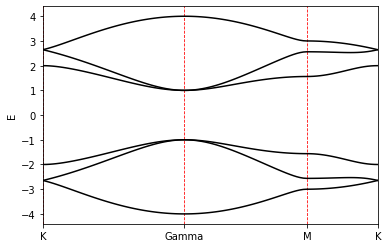

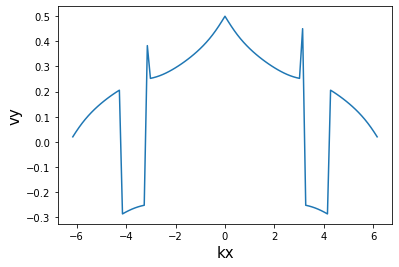

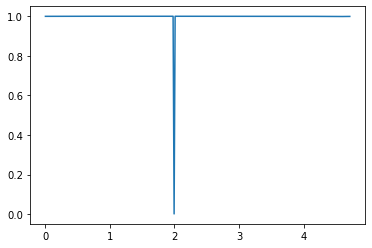

In [26]:
# 类比ssh模型推导扩张收缩后的三角晶格，不一定正确
def hamiltonian0(kx, ky, w=1, v=2, M=0):     # M不起作用，加入此变量只是为了调用能带图函数不出错
    h = np.zeros((6, 6))*(1+0j)
    for i in range(6):
        h[i,(i+1)%6] = w
        h[(i+1)%6,i] = w
        h[i,(i-1)%6] = w
        h[(i-1)%6,i] = w          
    h[0,3] = v*(cmath.exp(-1j*kx/2+1j*ky/2*sqrt(3)))
    h[1,4] = v*(cmath.exp(1j*kx/2+1j*ky/2*sqrt(3)))
    h[2,5] = v*(cmath.exp(1j*kx))
    for i in range(3):
        h[i+3,i] = h[i,i+3].conj()
    return h


def plot_Polarization0():    # 平移成菱形布里渊区沿kx方向的Berry phase(只积了ky方向，取平均即为体极化)
    nx = 101
    ny = 51
    kx_array = np.linspace(-2*pi,2*pi,nx)
    z_array = []
    for i in np.arange(1,nx-1):
        z = 1
        vector_size = hamiltonian0(0,0).shape[0]
        vector_array = np.zeros((ny,vector_size),dtype=complex)
        kx = kx_array[i]
        ky0 = (2*pi-abs(kx))/sqrt(3)
        ky_array = np.linspace(-ky0,ky0,ny)
        for j in np.arange(ny):
            ky = ky_array[j]
            H = hamiltonian0(kx, ky, M=M)
            eigenvalue, eigenvector = np.linalg.eig(H)
            vector = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]  # 价带波函数
            vector = find_vector_without_excess_phase(vector)
            vector_array[j] = vector            
        for j in np.arange(ny-1):
            A_x = np.dot(vector_array[j+1].transpose().conj(), vector_array[j])  # 贝里联络Ax（x分量）        
            z = np.dot(A_x,z)            
        z = np.log(z)/2/pi/1j
        z_array.append(z)
    z_array = np.array(z_array)
    fig,ax=plt.subplots()
    ax.plot(kx_array[1:nx-1],np.real(z_array))
    ax.set_xlabel('kx',fontsize=15)
    ax.set_ylabel('vy',fontsize=15)
    plt.show()
    
    
def energy_band_inversion(band_index):    
    dim = hamiltonian0(0,0).shape[0]
    kxky = np.linspace(0,3+np.sqrt(3),300)
    dim_k = kxky.shape[0]
    eigenvector_k = np.zeros((dim_k,dim),dtype=complex)
    for i in range(dim_k):
        xy = kxky[i]
        k1 = (xy<=2)*(2-xy) + (xy>2)*(xy<2+sqrt(3))*(xy-2)/2*sqrt(3) + (xy>=2+sqrt(3))*(2-(3+sqrt(3)-xy)/2)
        kx = k1*2*pi/3
        k2 = (xy>2)*(xy<2+sqrt(3))*(xy-2)/2 + (xy>=2+sqrt(3))*(3+sqrt(3)-xy)/2*sqrt(3)
        ky = k2*2*pi/3
        matrix0 = hamiltonian0(kx,ky,M=M)
        eigenvalue, eigenvector = np.linalg.eig(matrix0)
        vector = eigenvector[:, np.argsort(np.real(eigenvalue))[band_index]]
        vector = vector = find_vector_without_excess_phase(vector)
        eigenvector_k[i, :] = vector
        
    aa = []
    for i in range(dim_k-1):
        a = np.dot(eigenvector_k[i].transpose().conj(),eigenvector_k[i+1])
        aa.append(a.real)
    plt.plot(kxky[:-1],aa)
    plt.show()

    
#plot_bands_two_dimension(hamiltonian0)
#plot_Polarization0()
#energy_band_inversion(2)

